# Generates images from text prompts with a CLIP conditioned Decision Transformer.

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


In [1]:
!nvidia-smi

Thu Aug  5 19:17:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers
!pip install ftfy regex tqdm omegaconf pytorch-lightning einops transformers
!pip install -e ./taming-transformers

Cloning into 'CLIP'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 115 (delta 10), reused 16 (delta 9), pack-reused 91
Receiving objects: 100% (115/115), 6.25 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Cloning into 'taming-transformers'...
remote: Enumerating objects: 756, done.
remote: Total 756 (delta 0), reused 0 (delta 0), pack-reused 756
Receiving objects: 100% (756/756), 202.21 MiB | 35.30 MiB/s, done.
Resolving deltas: 100% (188/188), done.
     |████████████████████████████████| 64 kB 2.4 MB/s 
     |████████████████████████████████| 74 kB 3.4 MB/s 
     |████████████████████████████████| 915 kB 60.7 MB/s 
     |████████████████████████████████| 2.6 MB 49.7 MB/s 
     |████████████████████████████████| 112 kB 67.1 MB/s 
     |████████████████████████████████| 636 kB 48.3 MB/s 
     |████████████████████████████████| 829 kB 47.8 MB/s 
     |███████████████

Obtaining file:///content/taming-transformers
  Running setup.py develop for taming-transformers


In [3]:
!curl -OL --http1.1 'https://the-eye.eu/public/AI/models/cond_transformer_2/transformer_cond_2_00003_090000_modelonly.pth'
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' > vqgan_imagenet_f16_16384.yaml
!curl -L 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' > vqgan_imagenet_f16_16384.ckpt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1285M  100 1285M    0     0  49.2M      0  0:00:26  0:00:26 --:--:-- 50.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   692  100   692    0     0    989      0 --:--:-- --:--:-- --:--:--   989
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  934M  100  934M    0     0  14.6M      0  0:01:03  0:01:03 --:--:-- 14.9M


In [4]:
import argparse
from pathlib import Path
import sys

from IPython import display
from omegaconf import OmegaConf
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from transformers import top_k_top_p_filtering
from tqdm.notebook import trange

sys.path.append('./taming-transformers')

from CLIP import clip
from taming.models import vqgan

In [8]:
class CausalTransformerEncoder(nn.TransformerEncoder):
    def forward(self, src, mask=None, src_key_padding_mask=None, cache=None):
        output = src

        if self.training:
            if cache is not None:
                raise ValueError("cache parameter should be None in training mode")
            for mod in self.layers:
                output = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)

            if self.norm is not None:
                output = self.norm(output)

            return output

        new_token_cache = []
        compute_len = src.shape[0]
        if cache is not None:
            compute_len -= cache.shape[1]
        for i, mod in enumerate(self.layers):
            output = mod(output, compute_len=compute_len)
            new_token_cache.append(output)
            if cache is not None:
                output = torch.cat([cache[i], output], dim=0)

        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache


class CausalTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, compute_len=None):
        if self.training:
            return super().forward(src, src_mask, src_key_padding_mask)

        if compute_len is None:
            src_last_tok = src
        else:
            src_last_tok = src[-compute_len:, :, :]

        attn_mask = src_mask if compute_len > 1 else None
        tmp_src = self.self_attn(src_last_tok, src, src, attn_mask=attn_mask,
                                 key_padding_mask=src_key_padding_mask)[0]
        src_last_tok = src_last_tok + self.dropout1(tmp_src)
        src_last_tok = self.norm1(src_last_tok)

        tmp_src = self.linear2(self.dropout(self.activation(self.linear1(src_last_tok))))
        src_last_tok = src_last_tok + self.dropout2(tmp_src)
        src_last_tok = self.norm2(src_last_tok)
        return src_last_tok


class CLIPToImageTransformer(nn.Module):
    def __init__(self, clip_dim, seq_len, n_toks):
        super().__init__()
        self.clip_dim = clip_dim
        d_model = 1024
        self.clip_in_proj = nn.Linear(clip_dim, d_model, bias=False)
        self.clip_score_in_proj = nn.Linear(1, d_model, bias=False)
        self.in_embed = nn.Embedding(n_toks, d_model)
        self.out_proj = nn.Linear(d_model, n_toks)
        layer = CausalTransformerEncoderLayer(d_model, d_model // 64, d_model * 4,
                                              dropout=0, activation='gelu')
        self.encoder = CausalTransformerEncoder(layer, 24)
        self.pos_emb = nn.Parameter(torch.zeros([seq_len + 1, d_model]))
        self.register_buffer('mask', self._generate_causal_mask(seq_len + 1), persistent=False)

    @staticmethod
    def _generate_causal_mask(size):
        mask = (torch.triu(torch.ones([size, size])) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0))
        mask[0, 1] = 0
        return mask

    def forward(self, clip_embed, clip_score, input=None, cache=None):
        if input is None:
            input = torch.zeros([len(clip_embed), 0], dtype=torch.long, device=clip_embed.device)
        clip_embed_proj = self.clip_in_proj(F.normalize(clip_embed, dim=1) * self.clip_dim**0.5)
        clip_score_proj = self.clip_score_in_proj(clip_score)
        embed = torch.cat([clip_embed_proj.unsqueeze(0),
                           clip_score_proj.unsqueeze(0),
                           self.in_embed(input.T)])
        embed_plus_pos = embed + self.pos_emb[:len(embed)].unsqueeze(1)
        mask = self.mask[:len(embed), :len(embed)]
        out, cache = self.encoder(embed_plus_pos, mask, cache=cache)
        return self.out_proj(out[1:]).transpose(0, 1), cache


## Settings for this run:

In [9]:
args = argparse.Namespace(
    prompt='fantasy space time',
    batch_size=16,
    clip_score=0.475,
    half=True,
    k=8,
    n=128,
    output='out',
    seed=0,
    temperature=1.,
    top_k=0,
    top_p=0.95,
)

### Actually do the run...

100%|███████████████████████████████████████| 354M/354M [00:06<00:00, 55.4MiB/s]


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


8.19kB [00:00, 75.0kB/s]                            


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt



Actual CLIP score for output 0: 0.29126


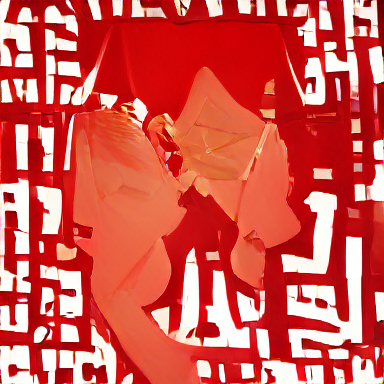

Actual CLIP score for output 1: 0.2854


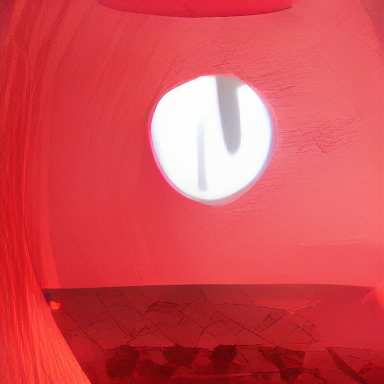

Actual CLIP score for output 2: 0.282959


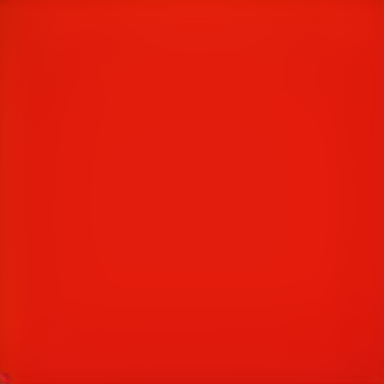

Actual CLIP score for output 3: 0.282471


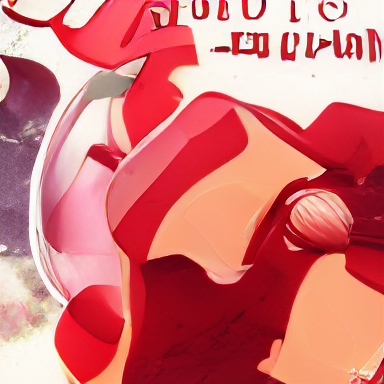

Actual CLIP score for output 4: 0.282227


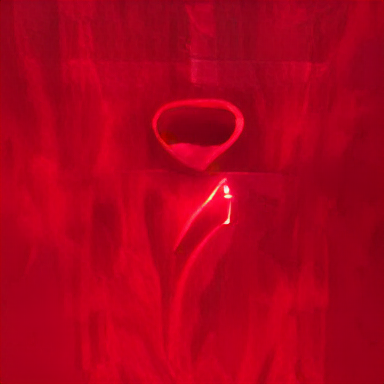

Actual CLIP score for output 5: 0.277832


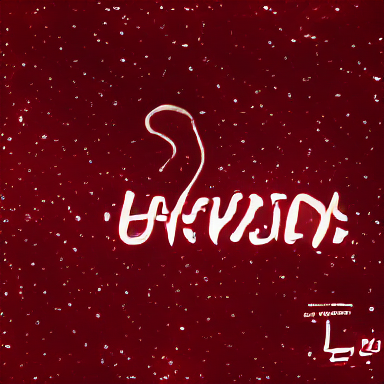

Actual CLIP score for output 6: 0.2771


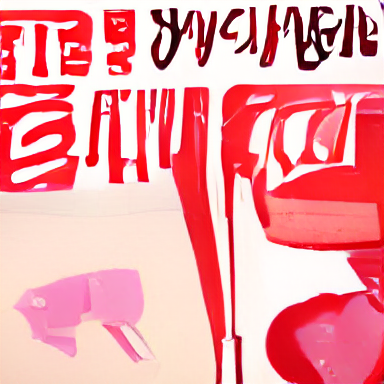

Actual CLIP score for output 7: 0.275635


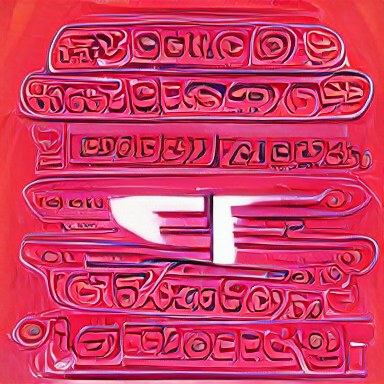

In [7]:
device = torch.device('cuda:0')
dtype = torch.half if args.half else torch.float

perceptor = clip.load('ViT-B/32', jit=False)[0].to(device).eval().requires_grad_(False)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
vqgan_config = OmegaConf.load('vqgan_imagenet_f16_16384.yaml')
vqgan_model = vqgan.VQModel(**vqgan_config.model.params).to(device)
vqgan_model.eval().requires_grad_(False)
vqgan_model.init_from_ckpt('vqgan_imagenet_f16_16384.ckpt')
del vqgan_model.loss

clip_dim = perceptor.visual.output_dim
clip_input_res = perceptor.visual.input_resolution
e_dim = vqgan_model.quantize.e_dim
f = 2**(vqgan_model.decoder.num_resolutions - 1)
n_toks = vqgan_model.quantize.n_e
size_x, size_y = 384, 384
toks_x, toks_y = size_x // f, size_y // f

model = CLIPToImageTransformer(clip_dim, toks_y * toks_x, n_toks)
ckpt = torch.load('transformer_cond_2_00003_090000_modelonly.pth', map_location='cpu')
model.load_state_dict(ckpt['model'])
del ckpt
model = model.to(device, dtype).eval().requires_grad_(False)

if args.seed is not None:
    torch.manual_seed(args.seed)

text_embed = perceptor.encode_text(clip.tokenize(args.prompt).to(device)).to(dtype)
text_embed = text_embed.repeat([args.n, 1])
clip_score = torch.ones([text_embed.shape[0], 1], device=device, dtype=dtype) * args.clip_score

@torch.no_grad()
def sample(clip_embed, clip_score, temperature=1., top_k=0, top_p=1.):
    tokens = torch.zeros([len(clip_embed), 0], dtype=torch.long, device=device)
    cache = None
    for i in trange(toks_y * toks_x, leave=False):
        logits, cache = model(clip_embed, clip_score, tokens, cache=cache)
        logits = logits[:, -1] / temperature
        logits = top_k_top_p_filtering(logits, top_k, top_p)
        next_token = logits.softmax(1).multinomial(1)
        tokens = torch.cat([tokens, next_token], dim=1)
    return tokens

def decode(tokens):
    z = vqgan_model.quantize.embedding(tokens).view([-1, toks_y, toks_x, e_dim]).movedim(3, 1)
    return vqgan_model.decode(z).add(1).div(2).clamp(0, 1)

try:
    out_lst, sim_lst = [], []
    for i in trange(0, len(text_embed), args.batch_size):
        tokens = sample(text_embed[i:i+args.batch_size], clip_score[i:i+args.batch_size],
                        temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
        out = decode(tokens)
        out_lst.append(out)
        out_for_clip = F.interpolate(out, (clip_input_res, clip_input_res),
                                     mode='bilinear', align_corners=False)
        image_embed = perceptor.encode_image(normalize(out_for_clip)).to(dtype)
        sim = torch.cosine_similarity(text_embed[i:i+args.batch_size], image_embed)
        sim_lst.append(sim)
    out = torch.cat(out_lst)
    sim = torch.cat(sim_lst)
    best_values, best_indices = sim.topk(min(args.k, args.n))
    for i, index in enumerate(best_indices):
        filename = args.output + f'_{i:03}.png'
        TF.to_pil_image(out[index]).save(filename)
        print(f'Actual CLIP score for output {i}: {best_values[i].item():g}')
        display.display(display.Image(filename))
except KeyboardInterrupt:
    pass


## Taylor Swift Song

In [11]:
args = argparse.Namespace(
    prompt='Say you will remember me standing in a nice dress Staring at the sunset babe Red lips and rosy cheeks Say you will see me again Even if it is just in your wildest dreams Wildest dreams',
    batch_size=16,
    clip_score=0.475,
    half=True,
    k=8,
    n=128,
    output='out',
    seed=0,
    temperature=1.,
    top_k=0,
    top_p=0.95,
)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt



Actual CLIP score for output 0: 0.248779


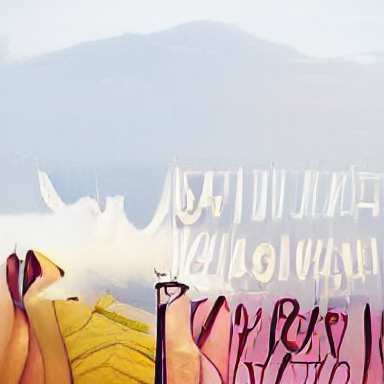

Actual CLIP score for output 1: 0.244263


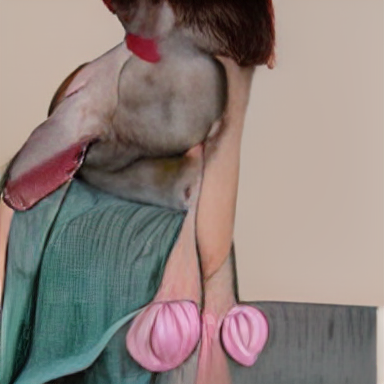

Actual CLIP score for output 2: 0.242676


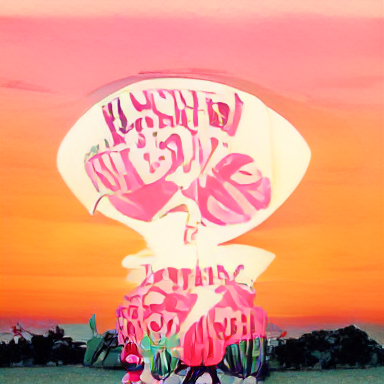

Actual CLIP score for output 3: 0.241333


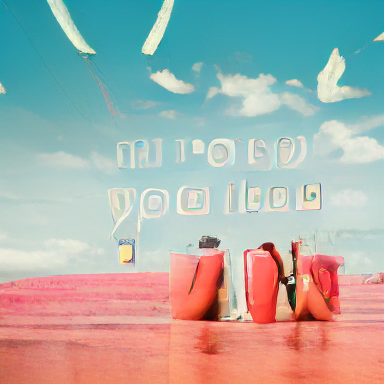

Actual CLIP score for output 4: 0.236816


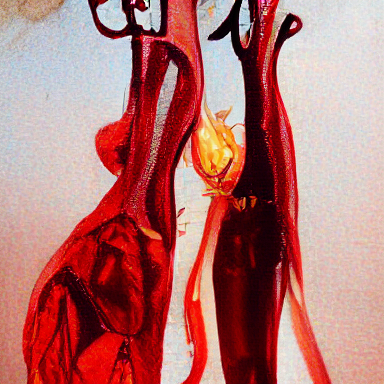

Actual CLIP score for output 5: 0.234253


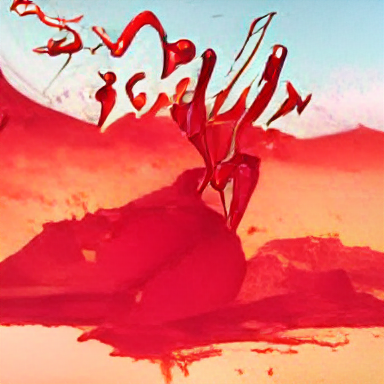

Actual CLIP score for output 6: 0.234131


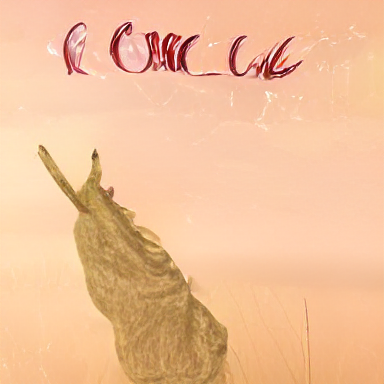

Actual CLIP score for output 7: 0.232788


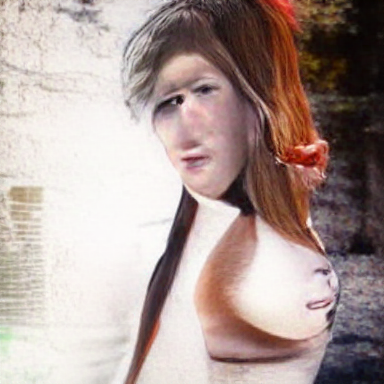

In [12]:
device = torch.device('cuda:0')
dtype = torch.half if args.half else torch.float

perceptor = clip.load('ViT-B/32', jit=False)[0].to(device).eval().requires_grad_(False)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
vqgan_config = OmegaConf.load('vqgan_imagenet_f16_16384.yaml')
vqgan_model = vqgan.VQModel(**vqgan_config.model.params).to(device)
vqgan_model.eval().requires_grad_(False)
vqgan_model.init_from_ckpt('vqgan_imagenet_f16_16384.ckpt')
del vqgan_model.loss

clip_dim = perceptor.visual.output_dim
clip_input_res = perceptor.visual.input_resolution
e_dim = vqgan_model.quantize.e_dim
f = 2**(vqgan_model.decoder.num_resolutions - 1)
n_toks = vqgan_model.quantize.n_e
size_x, size_y = 384, 384
toks_x, toks_y = size_x // f, size_y // f

model = CLIPToImageTransformer(clip_dim, toks_y * toks_x, n_toks)
ckpt = torch.load('transformer_cond_2_00003_090000_modelonly.pth', map_location='cpu')
model.load_state_dict(ckpt['model'])
del ckpt
model = model.to(device, dtype).eval().requires_grad_(False)

if args.seed is not None:
    torch.manual_seed(args.seed)

text_embed = perceptor.encode_text(clip.tokenize(args.prompt).to(device)).to(dtype)
text_embed = text_embed.repeat([args.n, 1])
clip_score = torch.ones([text_embed.shape[0], 1], device=device, dtype=dtype) * args.clip_score

@torch.no_grad()
def sample(clip_embed, clip_score, temperature=1., top_k=0, top_p=1.):
    tokens = torch.zeros([len(clip_embed), 0], dtype=torch.long, device=device)
    cache = None
    for i in trange(toks_y * toks_x, leave=False):
        logits, cache = model(clip_embed, clip_score, tokens, cache=cache)
        logits = logits[:, -1] / temperature
        logits = top_k_top_p_filtering(logits, top_k, top_p)
        next_token = logits.softmax(1).multinomial(1)
        tokens = torch.cat([tokens, next_token], dim=1)
    return tokens

def decode(tokens):
    z = vqgan_model.quantize.embedding(tokens).view([-1, toks_y, toks_x, e_dim]).movedim(3, 1)
    return vqgan_model.decode(z).add(1).div(2).clamp(0, 1)

try:
    out_lst, sim_lst = [], []
    for i in trange(0, len(text_embed), args.batch_size):
        tokens = sample(text_embed[i:i+args.batch_size], clip_score[i:i+args.batch_size],
                        temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
        out = decode(tokens)
        out_lst.append(out)
        out_for_clip = F.interpolate(out, (clip_input_res, clip_input_res),
                                     mode='bilinear', align_corners=False)
        image_embed = perceptor.encode_image(normalize(out_for_clip)).to(dtype)
        sim = torch.cosine_similarity(text_embed[i:i+args.batch_size], image_embed)
        sim_lst.append(sim)
    out = torch.cat(out_lst)
    sim = torch.cat(sim_lst)
    best_values, best_indices = sim.topk(min(args.k, args.n))
    for i, index in enumerate(best_indices):
        filename = args.output + f'_{i:03}.png'
        TF.to_pil_image(out[index]).save(filename)
        print(f'Actual CLIP score for output {i}: {best_values[i].item():g}')
        display.display(display.Image(filename))
except KeyboardInterrupt:
    pass


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt



Actual CLIP score for output 0: 0.294678


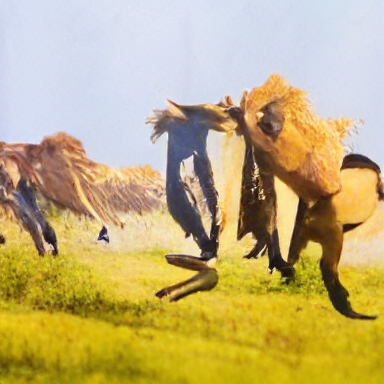

Actual CLIP score for output 1: 0.28418


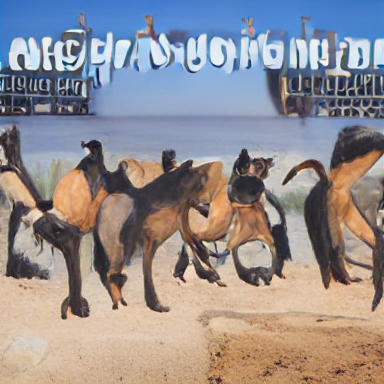

Actual CLIP score for output 2: 0.280273


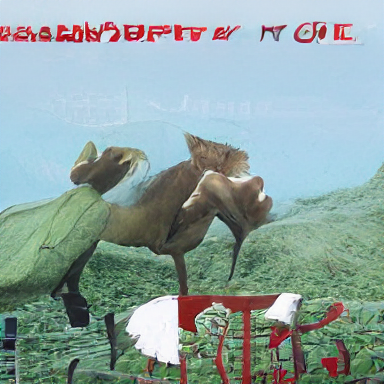

Actual CLIP score for output 3: 0.279297


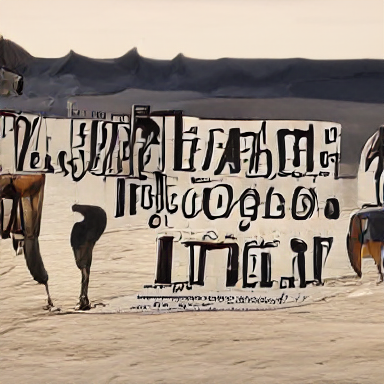

Actual CLIP score for output 4: 0.268799


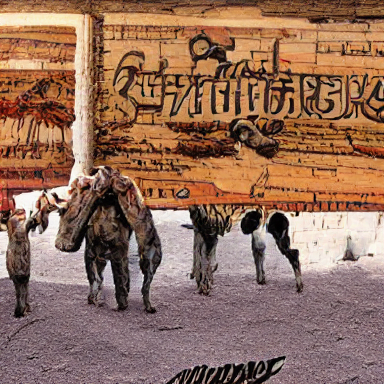

Actual CLIP score for output 5: 0.265625


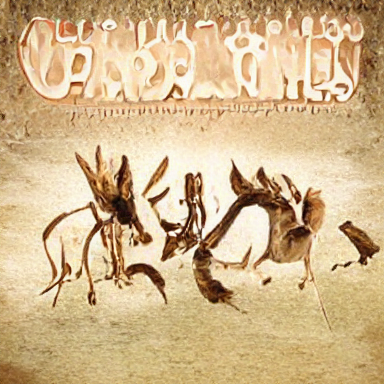

Actual CLIP score for output 6: 0.261475


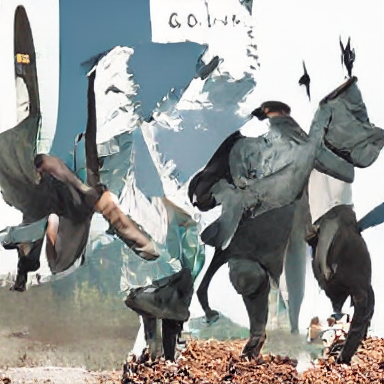

Actual CLIP score for output 7: 0.260742


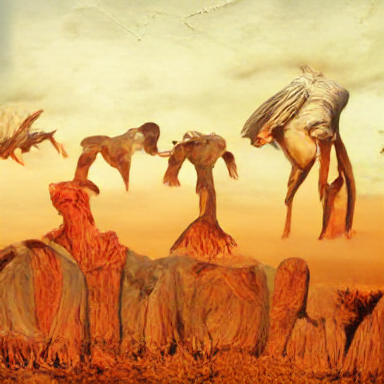

In [13]:
args = argparse.Namespace(
    prompt='Wildest horses ',
    batch_size=16,
    clip_score=0.475,
    half=True,
    k=8,
    n=128,
    output='out',
    seed=0,
    temperature=1.,
    top_k=0,
    top_p=0.95,
)


device = torch.device('cuda:0')
dtype = torch.half if args.half else torch.float

perceptor = clip.load('ViT-B/32', jit=False)[0].to(device).eval().requires_grad_(False)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
vqgan_config = OmegaConf.load('vqgan_imagenet_f16_16384.yaml')
vqgan_model = vqgan.VQModel(**vqgan_config.model.params).to(device)
vqgan_model.eval().requires_grad_(False)
vqgan_model.init_from_ckpt('vqgan_imagenet_f16_16384.ckpt')
del vqgan_model.loss

clip_dim = perceptor.visual.output_dim
clip_input_res = perceptor.visual.input_resolution
e_dim = vqgan_model.quantize.e_dim
f = 2**(vqgan_model.decoder.num_resolutions - 1)
n_toks = vqgan_model.quantize.n_e
size_x, size_y = 384, 384
toks_x, toks_y = size_x // f, size_y // f

model = CLIPToImageTransformer(clip_dim, toks_y * toks_x, n_toks)
ckpt = torch.load('transformer_cond_2_00003_090000_modelonly.pth', map_location='cpu')
model.load_state_dict(ckpt['model'])
del ckpt
model = model.to(device, dtype).eval().requires_grad_(False)

if args.seed is not None:
    torch.manual_seed(args.seed)

text_embed = perceptor.encode_text(clip.tokenize(args.prompt).to(device)).to(dtype)
text_embed = text_embed.repeat([args.n, 1])
clip_score = torch.ones([text_embed.shape[0], 1], device=device, dtype=dtype) * args.clip_score

@torch.no_grad()
def sample(clip_embed, clip_score, temperature=1., top_k=0, top_p=1.):
    tokens = torch.zeros([len(clip_embed), 0], dtype=torch.long, device=device)
    cache = None
    for i in trange(toks_y * toks_x, leave=False):
        logits, cache = model(clip_embed, clip_score, tokens, cache=cache)
        logits = logits[:, -1] / temperature
        logits = top_k_top_p_filtering(logits, top_k, top_p)
        next_token = logits.softmax(1).multinomial(1)
        tokens = torch.cat([tokens, next_token], dim=1)
    return tokens

def decode(tokens):
    z = vqgan_model.quantize.embedding(tokens).view([-1, toks_y, toks_x, e_dim]).movedim(3, 1)
    return vqgan_model.decode(z).add(1).div(2).clamp(0, 1)

try:
    out_lst, sim_lst = [], []
    for i in trange(0, len(text_embed), args.batch_size):
        tokens = sample(text_embed[i:i+args.batch_size], clip_score[i:i+args.batch_size],
                        temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
        out = decode(tokens)
        out_lst.append(out)
        out_for_clip = F.interpolate(out, (clip_input_res, clip_input_res),
                                     mode='bilinear', align_corners=False)
        image_embed = perceptor.encode_image(normalize(out_for_clip)).to(dtype)
        sim = torch.cosine_similarity(text_embed[i:i+args.batch_size], image_embed)
        sim_lst.append(sim)
    out = torch.cat(out_lst)
    sim = torch.cat(sim_lst)
    best_values, best_indices = sim.topk(min(args.k, args.n))
    for i, index in enumerate(best_indices):
        filename = args.output + f'_{i:03}.png'
        TF.to_pil_image(out[index]).save(filename)
        print(f'Actual CLIP score for output {i}: {best_values[i].item():g}')
        display.display(display.Image(filename))
except KeyboardInterrupt:
    pass


Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from vqgan_imagenet_f16_16384.ckpt



Actual CLIP score for output 0: 0.265381


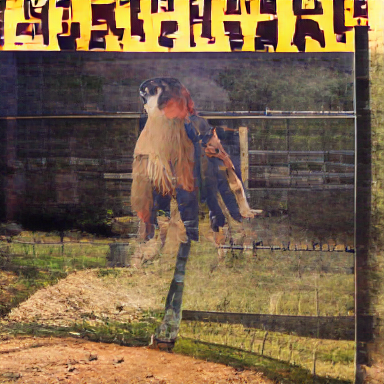

Actual CLIP score for output 1: 0.253906


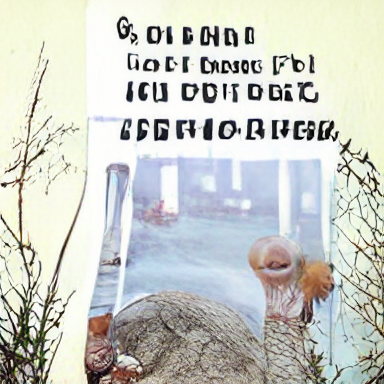

Actual CLIP score for output 2: 0.243774


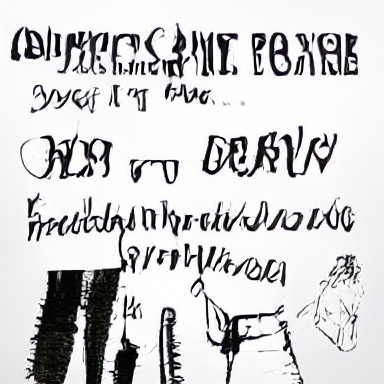

Actual CLIP score for output 3: 0.237061


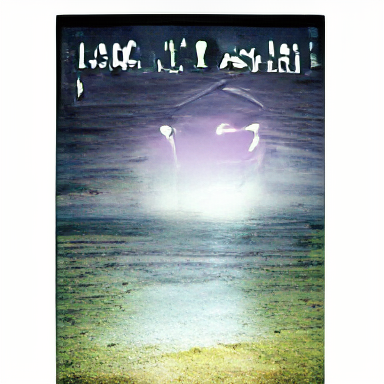

Actual CLIP score for output 4: 0.236206


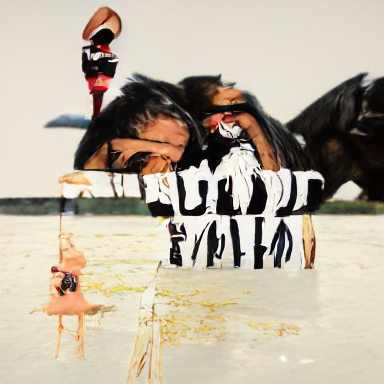

Actual CLIP score for output 5: 0.235718


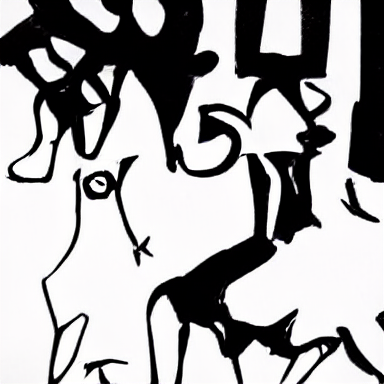

Actual CLIP score for output 6: 0.235718


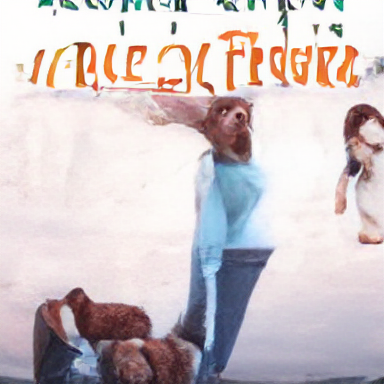

Actual CLIP score for output 7: 0.234009


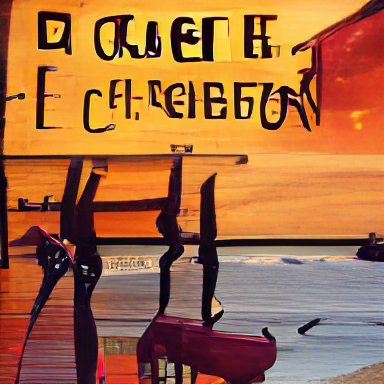

In [14]:
args = argparse.Namespace(
    prompt='Childhood living Is easy to do The things you wanted I bought them for you Graceless lady You know who I am You know I cannot let youSlide through my hands Wild horses Could not drag me away Wild, wild horses could not drag you away',
    batch_size=16,
    clip_score=0.475,
    half=True,
    k=8,
    n=128,
    output='out',
    seed=0,
    temperature=1.,
    top_k=0,
    top_p=0.95,
)


device = torch.device('cuda:0')
dtype = torch.half if args.half else torch.float

perceptor = clip.load('ViT-B/32', jit=False)[0].to(device).eval().requires_grad_(False)
normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])
vqgan_config = OmegaConf.load('vqgan_imagenet_f16_16384.yaml')
vqgan_model = vqgan.VQModel(**vqgan_config.model.params).to(device)
vqgan_model.eval().requires_grad_(False)
vqgan_model.init_from_ckpt('vqgan_imagenet_f16_16384.ckpt')
del vqgan_model.loss

clip_dim = perceptor.visual.output_dim
clip_input_res = perceptor.visual.input_resolution
e_dim = vqgan_model.quantize.e_dim
f = 2**(vqgan_model.decoder.num_resolutions - 1)
n_toks = vqgan_model.quantize.n_e
size_x, size_y = 384, 384
toks_x, toks_y = size_x // f, size_y // f

model = CLIPToImageTransformer(clip_dim, toks_y * toks_x, n_toks)
ckpt = torch.load('transformer_cond_2_00003_090000_modelonly.pth', map_location='cpu')
model.load_state_dict(ckpt['model'])
del ckpt
model = model.to(device, dtype).eval().requires_grad_(False)

if args.seed is not None:
    torch.manual_seed(args.seed)

text_embed = perceptor.encode_text(clip.tokenize(args.prompt).to(device)).to(dtype)
text_embed = text_embed.repeat([args.n, 1])
clip_score = torch.ones([text_embed.shape[0], 1], device=device, dtype=dtype) * args.clip_score

@torch.no_grad()
def sample(clip_embed, clip_score, temperature=1., top_k=0, top_p=1.):
    tokens = torch.zeros([len(clip_embed), 0], dtype=torch.long, device=device)
    cache = None
    for i in trange(toks_y * toks_x, leave=False):
        logits, cache = model(clip_embed, clip_score, tokens, cache=cache)
        logits = logits[:, -1] / temperature
        logits = top_k_top_p_filtering(logits, top_k, top_p)
        next_token = logits.softmax(1).multinomial(1)
        tokens = torch.cat([tokens, next_token], dim=1)
    return tokens

def decode(tokens):
    z = vqgan_model.quantize.embedding(tokens).view([-1, toks_y, toks_x, e_dim]).movedim(3, 1)
    return vqgan_model.decode(z).add(1).div(2).clamp(0, 1)

try:
    out_lst, sim_lst = [], []
    for i in trange(0, len(text_embed), args.batch_size):
        tokens = sample(text_embed[i:i+args.batch_size], clip_score[i:i+args.batch_size],
                        temperature=args.temperature, top_k=args.top_k, top_p=args.top_p)
        out = decode(tokens)
        out_lst.append(out)
        out_for_clip = F.interpolate(out, (clip_input_res, clip_input_res),
                                     mode='bilinear', align_corners=False)
        image_embed = perceptor.encode_image(normalize(out_for_clip)).to(dtype)
        sim = torch.cosine_similarity(text_embed[i:i+args.batch_size], image_embed)
        sim_lst.append(sim)
    out = torch.cat(out_lst)
    sim = torch.cat(sim_lst)
    best_values, best_indices = sim.topk(min(args.k, args.n))
    for i, index in enumerate(best_indices):
        filename = args.output + f'_{i:03}.png'
        TF.to_pil_image(out[index]).save(filename)
        print(f'Actual CLIP score for output {i}: {best_values[i].item():g}')
        display.display(display.Image(filename))
except KeyboardInterrupt:
    pass
